In [1]:
import tensorflow as tf
import numpy as np
from CNN import get_cnn
import os
import time
import datetime
import pickle
import csv
import gensim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

K = 400 # word2vec embedding dimension
L = 50 # 50 words limit for each sentence
NUM_CLASSES = 2

# Load CNN architecture
tf.reset_default_graph()

_x = tf.placeholder(tf.float32, [None, L, K], name='input_x')
_y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='input_y')


scores, predictions, loss, accuracy = get_cnn(_x, _y, 0)

print('CNN architecture loaded!')


MODEL_PATH = '../word2vec_twitter_model.bin'


W0617 13:54:43.154911 48668 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:24: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0617 13:54:43.166857 48668 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:31: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 13:54:43.211770 48668 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:56: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0617 13:54:47.900381 48668 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an i

CNN architecture loaded!


## Load word2vec model

In [2]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=3000000)
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=300000)
print('W2V loaded!')

W2V loaded!


## Load and preprocess testing dataset

In [3]:
''' load training dataset '''
TEST_DATA_PATH = 'dataset/test_set-actual-pure.csv' # the path of testing data

TWEETS_LIST = []
LABEL_LIST = []
with open(TEST_DATA_PATH, newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        TWEETS_LIST.append(row[2]) # the third row is the original text
        #TWEETS_LIST.append(row[1]) # the second row is the modified text

        if row[3] == '0':
            ''' Negative '''
            LABEL_LIST.append([1,0])
        else:
            ''' Positive '''
            LABEL_LIST.append([0,1])
print('Training dataset loaded')
print('Number of tweets in training dataset: ',len(TWEETS_LIST))

''' preprocess data '''
x_test = []
for tweet in TWEETS_LIST:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word]) # find word from W2V
        except:
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_test.append(np.array(tmp))
x_test = np.array(x_test)
y_test = np.array(LABEL_LIST)

''' Random shuffle the data '''
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(x_test)))
x_test = x_test[shuffle_indices]
y_test = y_test[shuffle_indices]

print('Data Preprocessed!')

Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!


# Make predictions

In [4]:
def precision(TP, FP):
    return TP.sum()/(TP.sum() + FP.sum())
    
def recall(TP, FN):
    return TP.sum()/(TP.sum() + FN.sum())

def F1(TP, FP, FN):
    p = precision(TP, FP)
    r = recall(TP, FN)
    return 2*(p*r)/(p+r)

def acc(TP,TN,FP,FN):
    return (TP.sum()+TN.sum())/(TP.sum()+TN.sum()+FP.sum()+FN.sum())

def significant_test(pred, y_test):
    TP = np.zeros(len(pred)) # true positive
    TN = np.zeros(len(pred)) # true negative
    FP = np.zeros(len(pred)) # false positive
    FN = np.zeros(len(pred)) # false negative
    try:
        for i in range(len(pred)):
            if pred[i] == y_test[i,1] and y_test[i,1] == 1:
                TP[i] = 1
            elif pred[i] == y_test[i,1] and y_test[i,1] == 0:
                TN[i] = 1
            elif pred[i] != y_test[i,1] and y_test[i,1] == 1:
                FP[i] = 1
            elif pred[i] != y_test[i,1] and y_test[i,1] == 0:
                FN[i] = 1
    except:
        for i in range(len(pred)):
            if pred[i] == y_test[i] and y_test[i] == 1:
                TP[i] = 1
            elif pred[i] == y_test[i] and y_test[i] == 0:
                TN[i] = 1
            elif pred[i] != y_test[i] and y_test[i] == 1:
                FP[i] = 1
            elif pred[i] != y_test[i] and y_test[i] == 0:
                FN[i] = 1
    return TP,TN,FP,FN

## Important!  If you have a very big testing dataset, don't feed it into the network all at once!!
## pred is the list of binary labels, e.g., [0,1,0,0,0,0,1,1,1, ... ,0,1,0,0]

In [5]:
sess = tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))
# Load parameters
saver = tf.train.Saver()
saver.restore(sess, 'saved_model-best/model.ckpt')
scor, pred, accu = sess.run([scores, predictions, accuracy], feed_dict={_x: x_test, _y: y_test})
print('Accuracy: ', accu)
TP,TN,FP,FN = significant_test(pred, y_test)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))

W0617 15:09:36.438174 48668 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Accuracy:  0.82403845
Precision:  0.8986866791744841
Recall:  0.787828947368421
F1:  0.8396143733567046
Accuracy:  0.8240384615384615


# Plot ROC Curve (CNN trained on original+synthetic dataset)

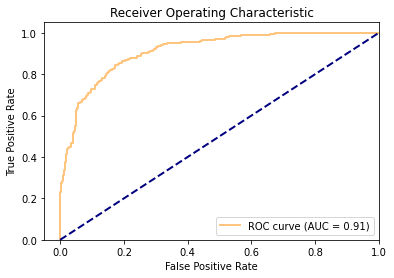

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

positive_scores = np.zeros(len(scor))
for i in range(len(scor)):
    positive_scores[i] = sigmoid(scor[i][1] - scor[i][0])
    
ground_truth = np.zeros(len(y_test), dtype=int)
for i in range(len(y_test)):
    if y_test[i][1] == 1:
        ground_truth[i] = 1
        

fpr_cnn_12661, tpr_cnn_12661, thresholds_cnn_12661 = roc_curve(ground_truth, positive_scores)
roc_auc_cnn_12661 = auc(fpr_cnn_12661, tpr_cnn_12661)
lw = 2
plt.figure()
plt.plot(fpr_cnn_12661, tpr_cnn_12661, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc_cnn_12661, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # diagonal line
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# ROC (CNN trained on original dataset)

In [7]:
sess = tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))
# Load parameters
saver = tf.train.Saver()
saver.restore(sess, 'saved_model-2700/model.ckpt')
scor, pred, accu = sess.run([scores, predictions, accuracy], feed_dict={_x: x_test, _y: y_test})
print('Accuracy: ', accu)
TP,TN,FP,FN = significant_test(pred, y_test)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))

Accuracy:  0.7653846
Precision:  0.6041275797373359
Recall:  0.9070422535211268
F1:  0.7252252252252253
Accuracy:  0.7653846153846153


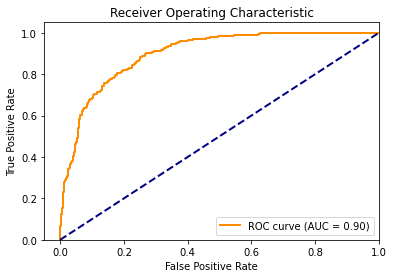

In [8]:
positive_scores = np.zeros(len(scor))
for i in range(len(scor)):
    positive_scores[i] = sigmoid(scor[i][1] - scor[i][0])
    
ground_truth = np.zeros(len(y_test), dtype=int)
for i in range(len(y_test)):
    if y_test[i][1] == 1:
        ground_truth[i] = 1
        
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr_cnn_2700, tpr_cnn_2700, thresholds_cnn_2700 = roc_curve(ground_truth, positive_scores)
roc_auc_cnn_2700 = auc(fpr_cnn_2700, tpr_cnn_2700)
lw = 2
plt.figure()
plt.plot(fpr_cnn_2700, tpr_cnn_2700, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc_cnn_2700)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # diagonal line
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Get the ROC for other ML models

In [36]:
## Logistic model 1: based on friend count
logistic_1_targets = []
logistic_1_scores = []
pred = []
with open('logistic_1.csv', newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        logistic_1_targets.append(int(row[1]))
        logistic_1_scores.append(float(row[2]))
        if float(row[2]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
pred = np.array(pred)
targets = np.array(logistic_1_targets)
print("\nlogistic_1: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))

## Logistic model 2: based on follower count   
logistic_2_targets = []
logistic_2_scores = []
pred = []
with open('logistic_2.csv', newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        logistic_2_targets.append(int(row[1]))
        logistic_2_scores.append(float(row[2]))
        if float(row[2]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
pred = np.array(pred)
targets = np.array(logistic_2_targets)
print("\nlogistic_2: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))

## DT model 
dt_targets = []
dt_scores = []
pred = []
with open('treeResult.csv', newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        dt_targets.append(int(row[1]))
        dt_scores.append(float(row[2]))
        if float(row[2]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
pred = np.array(pred)
targets = np.array(dt_targets)
print("\nDT: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))
        
        
fpr_logistic_1, tpr_logistic_1, thresholds_logistic_1 = roc_curve(logistic_1_targets, logistic_1_scores)
roc_auc_logistic_1 = auc(fpr_logistic_1, tpr_logistic_1)

fpr_logistic_2, tpr_logistic_2, thresholds_logistic_2 = roc_curve(logistic_2_targets, logistic_2_scores)
roc_auc_logistic_2 = auc(fpr_logistic_2, tpr_logistic_2)

fpr_dt, tpr_dt, thresholds_dt = roc_curve(dt_targets, dt_scores)
roc_auc_dt = auc(fpr_dt, tpr_dt)



logistic_1: 
Precision:  0.8730769230769231
Recall:  0.54632972322503
F1:  0.6720947446336046
Accuracy:  0.574447646493756

logistic_2: 
Precision:  0.9538461538461539
Recall:  0.5248677248677248
F1:  0.6771331058020478
Accuracy:  0.5456292026897214

DT: 
Precision:  0.925
Recall:  0.5844471445929527
F1:  0.7163067758749069
Accuracy:  0.6340057636887608


## ROC for all

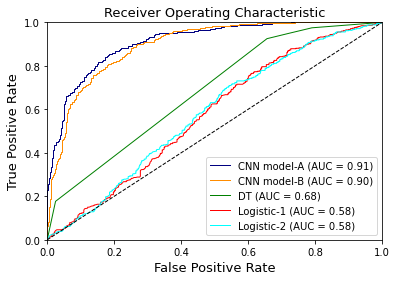

In [10]:
lw = 1
plt.figure()
plt.plot(fpr_cnn_12661, tpr_cnn_12661, color='navy', lw=lw, label='CNN model-A (AUC = %0.2f)' % roc_auc_cnn_12661, alpha=1)
plt.plot(fpr_cnn_2700, tpr_cnn_2700, color='darkorange', lw=lw, label='CNN model-B (AUC = %0.2f)' % roc_auc_cnn_2700, alpha=1)
plt.plot(fpr_dt, tpr_dt, color='green', lw=lw, label='DT (AUC = %0.2f)' % roc_auc_dt, alpha=1)
plt.plot(fpr_logistic_1, tpr_logistic_1, color='red', lw=lw, label='Logistic-1 (AUC = %0.2f)' % roc_auc_logistic_1, alpha=1)
plt.plot(fpr_logistic_2, tpr_logistic_2, color='cyan', lw=lw, label='Logistic-2 (AUC = %0.2f)' % roc_auc_logistic_2, alpha=1)

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--') # diagonal line
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic', fontsize=13)
plt.legend(loc="lower right")
plt.savefig("Figures/"+"ROCs.png",dpi=1000)

plt.show()

In [11]:
"""use PCA to reduce the dimension of word2vec"""
w2v_model_2 = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=100000)
word_vectors = []
for word in list(w2v_model_2.wv.vocab):
    word_vectors.append(w2v_model_2[word])


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [12]:
word_vectors = np.array(word_vectors)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(word_vectors)


PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [14]:
pca.transform([w2v_model["apple"]])

array([[-0.33070815, -1.0233363 , -0.14618483,  0.20132783,  0.13659164,
         0.424883  ,  1.3661401 , -0.48204353, -0.07826576,  0.69179314]],
      dtype=float32)

In [18]:
from tqdm import tqdm_notebook as tqdm
import xgboost as xgb

DIM_RANGE = [10,20,30,40,50,60,70,80,90,100]
P_svm = [] 
R_svm =  []
F1_svm = []
ACC_svm = []
P_xgb = [] 
R_xgb =  []
F1_xgb = []
ACC_xgb = []

for DIM in tqdm(DIM_RANGE):
    pca = PCA(n_components=DIM)
    pca.fit(word_vectors)
    
    ''' load training dataset '''
    TRAIN_SET_NAME = 'train_set_original'
    TRAIN_DATA_PATH = 'dataset/'+TRAIN_SET_NAME+'.csv'
    TWEETS_LIST = []
    LABEL_LIST = []
    with open(TRAIN_DATA_PATH, newline='') as csvfile:
        csvreader = list(csv.reader(csvfile, delimiter=','))
        for row in csvreader[1:]:
            TWEETS_LIST.append(row[2]) # the third row is the original text
            #TWEETS_LIST.append(row[1]) # the second row is the modified text

            if row[3] == '0':
                ''' Negative '''
                LABEL_LIST.append([1,0])
            else:
                ''' Positive '''
                LABEL_LIST.append([0,1])
    print('Training dataset loaded')
    print('Number of tweets in training dataset: ',len(TWEETS_LIST))

    ''' load lookup table '''
    with (open('dataset/'+TRAIN_SET_NAME+'.lookup', 'rb')) as openfile:
        try:
            LOADED_TABLE = pickle.load(openfile)
            print('Lookup table loaded')
        except EOFError:
            print('ERROR!')

    ''' preprocess data '''
    x_train = []
    for tweet in TWEETS_LIST:
        tmp = []
        for word in tweet.split(' '):
            try:
                vector = w2v_model[word]
                #vector = pca.transform([vector])
                #tmp.append(vector[0])
                tmp.append(vector[:DIM])
            except:
                ''' OOV word '''
                tmp.append(np.random.uniform(-0.5,0.5,DIM)) # random vector range:(-0.5, 0.5)
            if len(tmp) == L:
                break # 50 words limit!!
        while len(tmp) < L:
            ''' pad with zero vectors if less than 50 words '''
            tmp.append(np.zeros(DIM)) 
        x_train.append(np.array(tmp))
    x_train = np.array(x_train)
    y_train = np.array(LABEL_LIST)

    ''' Random shuffle the data '''
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    print('Data Preprocessed!')

    ''' load training dataset '''
    TEST_DATA_PATH = 'dataset/test_set-actual-pure.csv'
    TWEETS_LIST = []
    LABEL_LIST = []
    with open(TEST_DATA_PATH, newline='') as csvfile:
        csvreader = list(csv.reader(csvfile, delimiter=','))
        for row in csvreader[1:]:
            TWEETS_LIST.append(row[2]) # the third row is the original text
            #TWEETS_LIST.append(row[1]) # the second row is the modified text

            if row[3] == '0':
                ''' Negative '''
                LABEL_LIST.append([1,0])
            else:
                ''' Positive '''
                LABEL_LIST.append([0,1])
    print('Training dataset loaded')
    print('Number of tweets in training dataset: ',len(TWEETS_LIST))

    ''' preprocess data '''
    x_test = []
    for tweet in TWEETS_LIST:
        tmp = []
        for word in tweet.split(' '):
            try:
                vector = w2v_model[word]
                #vector = pca.transform([vector])
                #tmp.append(vector[0])
                tmp.append(vector[:DIM])
            except:
                ''' OOV word '''
                tmp.append(np.random.uniform(-0.5,0.5,DIM)) # random vector range:(-0.5, 0.5)
            if len(tmp) == L:
                break # 50 words limit!!
        while len(tmp) < L:
            ''' pad with zero vectors if less than 50 words '''
            tmp.append(np.zeros(DIM)) 
        x_test.append(np.array(tmp))
    x_test = np.array(x_test)
    y_test = np.array(LABEL_LIST)

    ''' Random shuffle the data '''
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(x_test)))
    x_test = x_test[shuffle_indices]
    y_test = y_test[shuffle_indices]

    print('Data Preprocessed!')

    x_train = x_train.reshape([-1,50*DIM])
    x_test = x_test.reshape([-1,50*DIM])
    y_train = y_train[:,1]
    y_test = y_test[:,1]

    """SVM"""
    from sklearn import svm
    clf = svm.SVC(gamma='scale', probability=True)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    pred = np.array(pred)
    targets = np.array(y_test)
    print("\n SVM: ")
    TP,TN,FP,FN = significant_test(pred, targets)
    print("Precision: ", precision(TP,FP))
    print("Recall: ", recall(TP, FN))
    print("F1: ", F1(TP, FP, FN))
    print("Accuracy: ",acc(TP,TN,FP,FN))
    P_svm.append(precision(TP,FP))
    R_svm.append(recall(TP, FN))
    F1_svm.append(F1(TP, FP, FN))
    ACC_svm.append(acc(TP,TN,FP,FN))
    
    """XGB"""
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 15, alpha = 10, n_estimators = 10)
    model.fit(x_train, y_train)
    scores = model.predict(x_test)
    pred = []
    for s in scores:
        if s > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    pred = np.array(pred)
    targets = np.array(y_test)
    print("\n XGBoost+CNN: ")
    TP,TN,FP,FN = significant_test(pred, targets)
    print("Precision: ", precision(TP,FP))
    print("Recall: ", recall(TP, FN))
    print("F1: ", F1(TP, FP, FN))
    print("Accuracy: ",acc(TP,TN,FP,FN))
    P_xgb.append(precision(TP,FP))
    R_xgb.append(recall(TP, FN))
    F1_xgb.append(F1(TP, FP, FN))
    ACC_xgb.append(acc(TP,TN,FP,FN))


Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.17073170731707318
Recall:  0.9479166666666666
F1:  0.2893481717011129
Accuracy:  0.5701923076923077


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.1200750469043152
Recall:  0.927536231884058
F1:  0.21262458471760798
Accuracy:  0.5442307692307692
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.1951219512195122
Recall:  0.9369369369369369
F1:  0.32298136645962733
Accuracy:  0.5807692307692308


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.12195121951219512
Recall:  0.8904109589041096
F1:  0.21452145214521448
Accuracy:  0.5423076923076923
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.18761726078799248
Recall:  0.9259259259259259
F1:  0.3120124804992199
Accuracy:  0.5759615384615384


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.12382739212007504
Recall:  0.9565217391304348
F1:  0.21926910299003322
Accuracy:  0.5480769230769231
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.2326454033771107
Recall:  0.9323308270676691
F1:  0.37237237237237236
Accuracy:  0.5980769230769231


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.1294559099437148
Recall:  0.9452054794520548
F1:  0.22772277227722768
Accuracy:  0.55
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.24577861163227016
Recall:  0.9492753623188406
F1:  0.39046199701937406
Accuracy:  0.6067307692307692


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.1575984990619137
Recall:  0.9438202247191011
F1:  0.270096463022508
Accuracy:  0.5634615384615385
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.2026266416510319
Recall:  0.9473684210526315
F1:  0.3338485316846986
Accuracy:  0.5855769230769231


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.13133208255159476
Recall:  0.8974358974358975
F1:  0.2291325695581015
Accuracy:  0.5471153846153847
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.19136960600375236
Recall:  0.9622641509433962
F1:  0.3192488262910798
Accuracy:  0.5817307692307693


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.1425891181988743
Recall:  0.9047619047619048
F1:  0.24635332252836306
Accuracy:  0.5528846153846154
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.225140712945591
Recall:  0.967741935483871
F1:  0.365296803652968
Accuracy:  0.5990384615384615


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.1275797373358349
Recall:  0.9066666666666666
F1:  0.2236842105263158
Accuracy:  0.5461538461538461
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.2101313320825516
Recall:  0.9739130434782609
F1:  0.34567901234567905
Accuracy:  0.5923076923076923


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.13696060037523453
Recall:  0.8588235294117647
F1:  0.23624595469255666
Accuracy:  0.5461538461538461
Training dataset loaded
Number of tweets in training dataset:  2660
Lookup table loaded
Data Preprocessed!
Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!

 SVM: 
Precision:  0.2176360225140713
Recall:  0.9508196721311475
F1:  0.35419847328244275
Accuracy:  0.5932692307692308


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.14634146341463414
Recall:  0.8478260869565217
F1:  0.2496
Accuracy:  0.5490384615384616



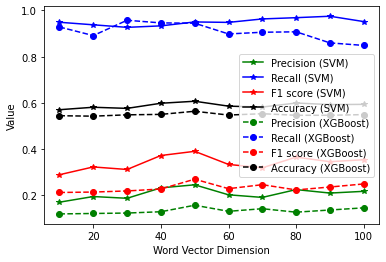

In [20]:
plt.plot(DIM_RANGE, P_svm, color='green', marker="*", label="Precision (SVM)")
plt.plot(DIM_RANGE, R_svm, color='blue', marker="*", label="Recall (SVM)")
plt.plot(DIM_RANGE, F1_svm, color='red', marker="*", label="F1 score (SVM)")
plt.plot(DIM_RANGE, ACC_svm, color='black', marker="*", label="Accuracy (SVM)")
plt.plot(DIM_RANGE, P_xgb, color='green', marker="o", ls="--", label="Precision (XGBoost)")
plt.plot(DIM_RANGE, R_xgb, color='blue', marker="o", ls="--", label="Recall (XGBoost)")
plt.plot(DIM_RANGE, F1_xgb, color='red', marker="o", ls="--", label="F1 score (XGBoost)")
plt.plot(DIM_RANGE, ACC_xgb, color='black', marker="o", ls="--", label="Accuracy (XGBoost)")
plt.legend()
#plt.ylim(top=25)
plt.ylabel("Value")
plt.xlabel("Word Vector Dimension")
#plt.savefig("Figures/SVM_XGB.png",dpi=500)
plt.show()

In [21]:
print(TP_xgb.sum())
print(TN_xgb.sum())
print(FP_xgb.sum())
print(FN_xgb.sum())

NameError: name 'TP_xgb' is not defined

In [22]:
scores = clf.predict_proba(x_test)
pred = clf.predict(x_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, scores[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

scores = model.predict(x_test)
pred = []
for s in scores:
    if s > 0.5:
        pred.append(1)
    else:
        pred.append(0)
pred = np.array(pred)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, scores)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

In [23]:
pred = np.array(pred)
targets = np.array(y_test)
print("\n SVM: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))


 SVM: 
Precision:  0.14634146341463414
Recall:  0.8478260869565217
F1:  0.2496
Accuracy:  0.5490384615384616


(12141, 320)

In [24]:
"""load deep feature"""
x_train_df = np.load("x_train_df.npy")
y_train_df = np.load("y_train_df.npy")
x_test_df = np.load("x_test_df.npy")
y_test_df = np.load("y_test_df.npy")

In [28]:
"""CNN (deep feature) + SVM"""
from sklearn import svm

clf = svm.SVC(gamma='scale', probability=True)
clf.fit(x_train_df, y_train_df[:,1])

scores = clf.predict_proba(x_test_df)
pred = clf.predict(x_test_df)

fpr_svm_cnn, tpr_svm_cnn, thresholds_svm_cnn = roc_curve(y_test_df[:,1], scores[:,1])
roc_auc_svm_cnn = auc(fpr_svm_cnn, tpr_svm_cnn)

pred = np.array(pred)
targets = np.array(y_test_df)
print("\n SVM+CNN: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))


 SVM+CNN: 
Precision:  0.874296435272045
Recall:  0.802065404475043
F1:  0.8366247755834829
Accuracy:  0.825


In [17]:
"""prepare the deepfeature data for XGBoost"""
"""
output_file = open("train_df.csv","w")
for i in range(len(x_train_df)):
    line = "" + str(y_train_df[i,1]) + " "
    for j in range(len(x_train_df[i])):
        line = line + str(j) + ":" + str(x_train_df[i,j])
    output_file.write(line+"\n")
output_file.close()

output_file = open("test_df.csv","w")
for i in range(len(x_test_df)):
    line = "" + str(y_test_df[i,1]) + " "
    for j in range(len(x_test_df[i])):
        line = line + str(j) + ":" + str(x_test_df[i,j])
    output_file.write(line+"\n")
output_file.close()
"""

'\noutput_file = open("train_df.csv","w")\nfor i in range(len(x_train_df)):\n    line = "" + str(y_train_df[i,1]) + " "\n    for j in range(len(x_train_df[i])):\n        line = line + str(j) + ":" + str(x_train_df[i,j])\n    output_file.write(line+"\n")\noutput_file.close()\n\noutput_file = open("test_df.csv","w")\nfor i in range(len(x_test_df)):\n    line = "" + str(y_test_df[i,1]) + " "\n    for j in range(len(x_test_df[i])):\n        line = line + str(j) + ":" + str(x_test_df[i,j])\n    output_file.write(line+"\n")\noutput_file.close()\n'

In [29]:
"""CNN (deep feature) + XGBoost"""
import xgboost as xgb
#dtrain = xgb.DMatrix('train_df.csv?format=csv&label_column=0')
#dtest = xgb.DMatrix('test_df.csv?format=csv&label_column=0')

model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 15, alpha = 10, n_estimators = 200)
model.fit(x_train_df, y_train_df[:,1])

scores = model.predict(x_test_df)
pred = []
for s in scores:
    if s > 0.5:
        pred.append(1)
    else:
        pred.append(0)
pred = np.array(pred)

fpr_xgb_cnn, tpr_xgb_cnn, thresholds_xgb_cnn = roc_curve(y_test_df[:,1], scores)
roc_auc_xgb_cnn = auc(fpr_xgb_cnn, tpr_xgb_cnn)

pred = np.array(pred)
targets = np.array(y_test_df[:,1])
print("\n XGBoost+CNN: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



 XGBoost+CNN: 
Precision:  0.9061913696060038
Recall:  0.7815533980582524
F1:  0.8392701998262381
Accuracy:  0.8221153846153846


In [42]:
## BERT model-A 
bertA_targets = []
bertA_scores = []
pred = []
with open('bert_A.csv', newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        bertA_targets.append(int(row[1]))
        bertA_scores.append(float(row[2]))
        if float(row[2]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
pred = np.array(pred)
targets = np.array(bertA_targets)
print("Bert A: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))
fpr_bertA, tpr_bertA, thresholds_bertA = roc_curve(bertA_targets, bertA_scores)
roc_auc_bertA = auc(fpr_bertA, tpr_bertA)


## BERT model-B
bertB_targets = []
bertB_scores = []
pred = []
with open('bert_B.csv', newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        bertB_targets.append(int(row[1]))
        bertB_scores.append(float(row[2]))
        if float(row[2]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
pred = np.array(pred)
targets = np.array(bertB_targets)
print("Bert B: ")
TP,TN,FP,FN = significant_test(pred, targets)
print("Precision: ", precision(TP,FP))
print("Recall: ", recall(TP, FN))
print("F1: ", F1(TP, FP, FN))
print("Accuracy: ",acc(TP,TN,FP,FN))
fpr_bertB, tpr_bertB, thresholds_bertB = roc_curve(bertB_targets, bertB_scores)
roc_auc_bertB = auc(fpr_bertB, tpr_bertB)


Bert A: 
Precision:  1.0
Recall:  1.0
F1:  1.0
Accuracy:  1.0
Bert B: 
Precision:  1.0
Recall:  1.0
F1:  1.0
Accuracy:  1.0


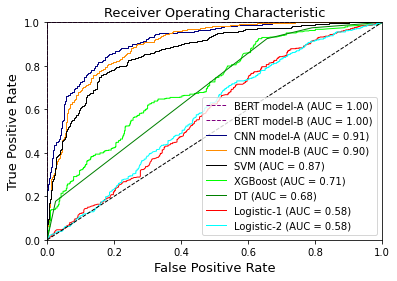

In [39]:
lw = 1
plt.figure()
#plt.plot(fpr_xgb_cnn, tpr_xgb_cnn, color='purple', lw=lw, label='CNN model-A + XGB (AUC = %0.2f)' % roc_auc_xgb_cnn, alpha=1)
plt.plot(fpr_bertA, tpr_bertA, color='purple', linestyle='--', lw=lw, label='BERT model-A (AUC = %0.2f)' % roc_auc_bertA, alpha=1)
plt.plot(fpr_bertB, tpr_bertB, color='purple', linestyle='--', lw=lw, label='BERT model-B (AUC = %0.2f)' % roc_auc_bertB, alpha=1)
plt.plot(fpr_cnn_12661, tpr_cnn_12661, color='navy', lw=lw, label='CNN model-A (AUC = %0.2f)' % roc_auc_cnn_12661, alpha=1)
plt.plot(fpr_cnn_2700, tpr_cnn_2700, color='darkorange', lw=lw, label='CNN model-B (AUC = %0.2f)' % roc_auc_cnn_2700, alpha=1)
plt.plot(fpr_svm, tpr_svm, color='black', lw=lw, label='SVM (AUC = %0.2f)' % roc_auc_svm, alpha=1)
plt.plot(fpr_xgb, tpr_xgb, color='lime', lw=lw, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb, alpha=1)
#plt.plot(fpr_svm_cnn, tpr_svm_cnn, color='lime', lw=lw, label='CNN model-A + SVM (AUC = %0.2f)' % roc_auc_svm_cnn, alpha=1)
plt.plot(fpr_dt, tpr_dt, color='green', lw=lw, label='DT (AUC = %0.2f)' % roc_auc_dt, alpha=1)
plt.plot(fpr_logistic_1, tpr_logistic_1, color='red', lw=lw, label='Logistic-1 (AUC = %0.2f)' % roc_auc_logistic_1, alpha=1)
plt.plot(fpr_logistic_2, tpr_logistic_2, color='cyan', lw=lw, label='Logistic-2 (AUC = %0.2f)' % roc_auc_logistic_2, alpha=1)

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--') # diagonal line
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver Operating Characteristic', fontsize=13)
plt.legend(loc="lower right")
#plt.savefig("Figures/"+"ROCs.png",dpi=600)

plt.show()